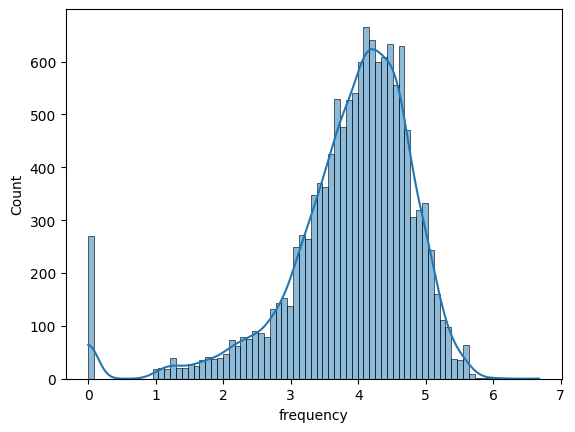

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df =  pd.read_csv('train.csv')
sns.histplot(df['frequency'], kde=True)
plt.show()


In [4]:
df.describe()

,Unnamed: 0,Native_Annotators,Non_Native_Annotators,Total_Annotators,complex_percentage,frequency
count,13256.000000,13256.000000,13256.000000,13256.000000,13256.000000,13256.000000
mean,6627.500000,2.344448,2.110290,4.454737,21.102897,3.885675
std,3826.821919,2.671549,2.536445,4.787753,25.364451,0.975544
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,3313.750000,1.000000,0.000000,1.000000,0.000000,3.480000
50%,6627.500000,1.000000,1.000000,2.000000,10.000000,4.060000
75%,9941.250000,3.000000,3.000000,6.000000,30.000000,4.520000
max,13255.000000,10.000000,10.000000,20.000000,100.000000,6.680000


In [2]:
import pandas as pd

def process_complexity(df, output_filename):
    # Find duplicates based on the 'Complex_phrase' column
    duplicates = df[df.duplicated('Complex_Phrase', keep=False)]
    
    # Group by Complex_phrase and calculate the average of complex_percentage
    # While keeping the first occurrence of the other columns
    df_processed = df.groupby('Complex_Phrase', as_index=False).agg({
        'complex_percentage': 'mean',  # Average complex_percentage
        'Complex_Phrase': 'first' 
          # Keep the first value of Complex_phrase (it will be the same for each group)
    })
    
    # Print out duplicates and their complex_percentage
    if not duplicates.empty:
        print("Words with duplicates and their complex percentages:")
        for word, group in duplicates.groupby('Complex_Phrase'):
            print(f"\nWord: {word}")
            print("Complex percentages:", group['complex_percentage'].values)
    
    # Save the processed DataFrame as a CSV file
    df_processed.to_csv(output_filename, index=False)
    return df_processed


df=  pd.read_csv('train_updated.csv')
process_complexity(df,'train_updated.csv')


Words with duplicates and their complex percentages:

Word: AFP
Complex percentages: [0. 0. 0. 0. 0. 0.]

Word: Aboriginal
Complex percentages: [50. 10. 10. 90.]

Word: Aboriginal land rights
Complex percentages: [10. 20.]

Word: Abrams tanks
Complex percentages: [ 0. 10.]

Word: According
Complex percentages: [0. 0. 0. 0. 0. 0.]

Word: According to
Complex percentages: [ 0. 10.  0. 10. 10.]

Word: Activists
Complex percentages: [60. 40.]

Word: Adnan
Complex percentages: [ 0. 10.]

Word: Aemilian
Complex percentages: [ 0. 10.  0.]

Word: Affordable
Complex percentages: [30. 10.]

Word: Afghanistan
Complex percentages: [0. 0. 0.]

Word: Afghans
Complex percentages: [0. 0. 0.]

Word: Afterwards
Complex percentages: [20.  0. 40.]

Word: Akilam
Complex percentages: [0. 0. 0.]

Word: Alawite
Complex percentages: [20. 10. 10. 10. 10. 10.]

Word: Alawite sect
Complex percentages: [10. 10. 10.]

Word: Aldeburgh
Complex percentages: [10. 10. 10.  0.]

Word: Alexei Mechkov
Complex percentages: 

,complex_percentage,Complex_Phrase
0,0.0,liquors
1,0.0,membranous structure
2,10.0,A major
3,10.0,AAC
4,20.0,ACA
...,...,...
8256,0.0,معمار سينان
8257,10.0,“Duck
8258,20.0,“Duck and cover
8259,0.0,“take cover


In [3]:
import pandas as pd
from collections import defaultdict

def process_complexity(df, output_filename):
    # Convert all phrases to lowercase to ensure case insensitivity
    df['Complex_Phrase'] = df['Complex_Phrase'].str.lower()
    
    # Create a dictionary to map existing single words to their complex_percentage
    word_dict = pd.Series(df['complex_percentage'].values, index=df['Complex_Phrase']).to_dict()

    # Dictionary to store inherited complexities for words from multi-word phrases
    inherited_complexities = defaultdict(list)

    # Process multi-word phrases
    for phrase, percentage in word_dict.items():
        words = phrase.split()  # Split phrase into individual words
        if len(words) > 1:  # Only process if it's a multi-word phrase
            for word in words:
                # If word already exists separately, it retains its own complexity
                if word not in word_dict:
                    inherited_complexities[word].append(percentage)

    # Calculate the average complexity for words that appeared in multiple phrases but not separately
    for word, percentages in inherited_complexities.items():
        word_dict[word] = sum(percentages) / len(percentages)

    # Remove multi-word phrases from the dataset
    single_word_dict = {word: complexity for word, complexity in word_dict.items() if ' ' not in word}

    # Convert the processed word dictionary to a DataFrame
    transformed_df = pd.DataFrame(list(single_word_dict.items()), columns=['Complex_Phrase', 'complex_percentage'])

    # Save the transformed DataFrame to CSV
    transformed_df.to_csv(output_filename, index=False)
    return transformed_df

# Example usage
df = pd.read_csv('train_updated.csv')

process_complexity(df, 'train_updated.csv')



,Complex_Phrase,complex_percentage
0,aac,10.0
1,aca,20.0
2,acf,10.0
3,afp,0.0
4,ap,0.0
...,...,...
5918,date,5.0
5919,ˈalfons,0.0
5920,ˈmuxa,0.0
5921,“take,0.0


In [27]:
from nltk.corpus import stopwords

def remove_stopwords(df):
    stop_words = set(stopwords.words('english'))
    df = df[~df['Complex_Phrase'].isin(stop_words)]
    df.to_csv('dev.csv',index=False)



df = pd.read_csv('dev.csv')

remove_stopwords(df)



In [ ]:
import nltk
from nltk.corpus import words
import pandas as pd
import enchant

# Download the words dataset if not already downloaded
nltk.download('words')

# Load the English words set
english_words = set(words.words())

# Initialize enchant dictionary for better word detection
dictionary = enchant.Dict("en_US")

def is_english_word(word):
    # Check if the word is in the nltk words list or if it is valid in the enchant dictionary
    return word.lower() in english_words or dictionary.check(word)

def remove_non_english_words(df):
    # Collect non-English words for printing
    non_english_words = df[~df['Complex_Phrase'].apply(is_english_word)]['Complex_Phrase'].tolist()

    if non_english_words:
        print("Non-English words found and removed:")
        for word in non_english_words:
            print(word)

    # Filter the DataFrame to keep only rows where Complex_phrase is an English word
    df_filtered = df[df['Complex_Phrase'].apply(is_english_word)]
    return df_filtered

# Example usage
df = pd.read_csv('dev.csv')

df_filtered = remove_non_english_words(df)
df_filtered.to_csv('dev.csv')


Non-English words found and removed:
aac
aca
acf
afp
ap
ar-kiv-ist
ar-kive-ist
académie
accroche-coeurs
acherontia
adnan
aemilian
aemilianus
afghanistan
afghanistan’s
agrofert
agus
agência
ahmedabad
ain
airasia
akilam
al-qaeda-inspired
alawite
albanian
alcaçuz
aldeburgh
allerton
amazonas
amitas
andretti
angara
anti-putin
antrim
antyscience
apollo
apollo-soyuz
aquarius
aquinas
aquino
araujo
ariodante
arjen
arovell
assad
assads
assange
australian
austria
austria.svg
austrian
autosport
ayrton
ayyavazhi
azores
bbc
bbva
bbs
brp
baden-württemberg
bagram
baldetti
ballyfermot
bankia
banksy
barack
bayerns
beaconsfield
beauveria
beethoven
belfast
bellaghy
bernhardt
bethany
bianchi
bianchis
biddle
bidens
bild
birtwistle
bishkek
blackpool
blythburgh
bondaroy
borno
bos
brahms
braunau
brazilian
brexit
bridgeport
britten-pears
brookings
bruck
bulgaria
bulgarian
bundesliga
bundesländer
burmese
bützow
cctv
ceo
california-based
campesino
canadian
canadiens
canaveral
cantwell
caoimhe
carly
carondelet
cas

[nltk_data] Downloading package words to
[nltk_data]     /Users/parvizpirizade/nltk_data...
[nltk_data]   Package words is already up-to-date!
